In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Import the necessary libraries.
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
#!pip install pyod            # normal install
#!pip install --upgrade pyod  # or update if needed
from pyod.models.pca import PCA as PCA_PYOD
from pyod.models.kpca import KPCA as KPCA_PYOD
from scipy.io import loadmat
import os
import seaborn as sns
from sklearn.metrics import f1_score

In [2]:
vowel = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.data'


In [3]:
#Vowel dataset we select the fist and the second vowel
vowel_data = pd.read_csv(vowel,skiprows=2, index_col=False,delim_whitespace=True)
vowel_data.columns = ['feature{}'.format(i) for i in range(0,vowel_data.shape[1])]

vowel_data.shape,vowel_data.nunique().tolist()[-1:]

((987, 14), [11])

In [4]:
Counter(vowel_data['feature13']==0)

Counter({False: 898, True: 89})

In [5]:

#vowel1_dataset.query('feature13 == True')
vowel1_dataset = vowel_data.copy()
vowel1_dataset['feature13']= (vowel1_dataset['feature13']==1)
vowel1_dataset = vowel1_dataset.drop(vowel1_dataset[vowel1_dataset['feature13'] == False].sample(frac=0.96).index)

In [6]:
Counter(vowel1_dataset['feature13'])

Counter({True: 89, False: 36})

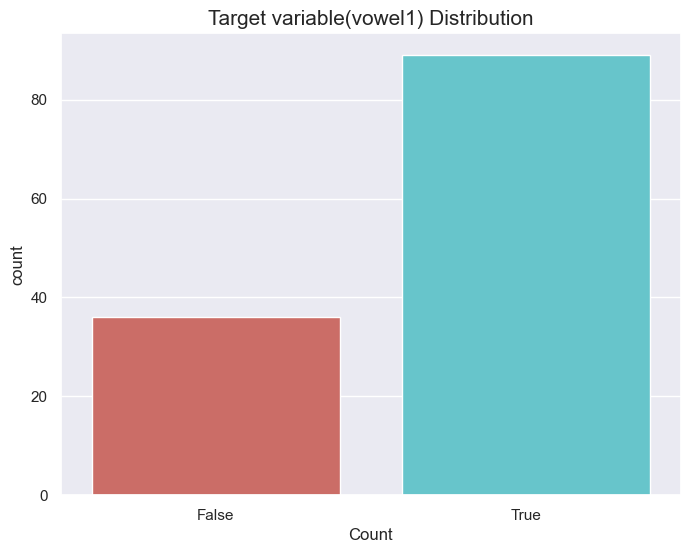

In [7]:
sns.set(rc = {'figure.figsize':(8,6)})
g1 = sns.countplot(x="feature13",data= vowel1_dataset, palette="hls")                  
g1.set_title("Target variable(vowel1) Distribution", fontsize=15)
g1.set_xlabel("Vowel1")
g1.set_xlabel("Count")
plt.show()

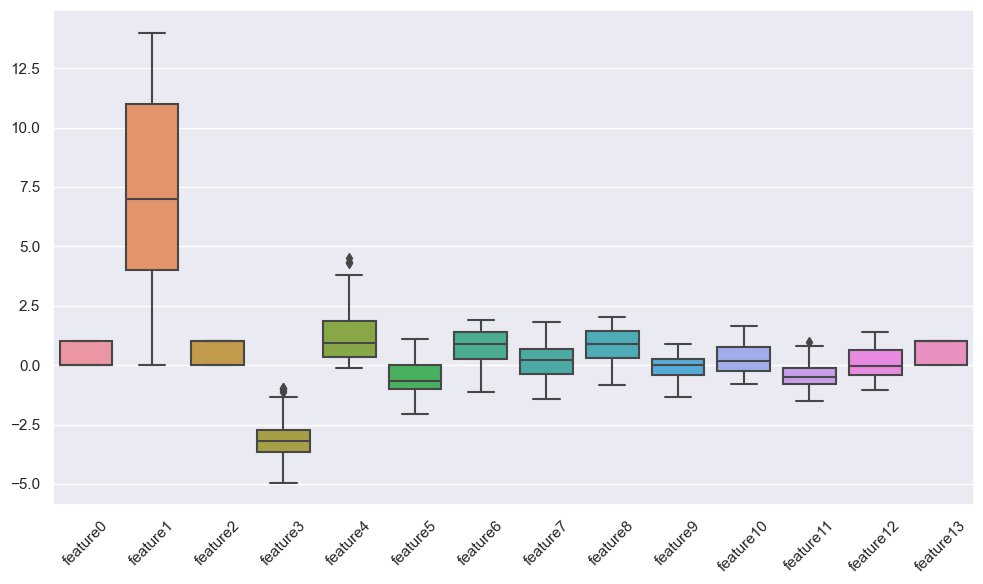

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
box = sns.boxplot(data=vowel1_dataset) 
box.set_xticklabels(box.get_xticklabels(), rotation= 45) 
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

### SVM

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(vowel1_dataset)

In [10]:
vowel1_dataset

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13
9,0,0,0,-3.237,0.436,-0.860,1.363,-0.251,1.915,-0.395,0.751,-0.774,-0.327,True
20,0,0,0,-3.165,0.408,-0.971,1.207,-0.298,1.921,-0.215,0.723,-0.492,-0.425,True
31,0,0,0,-3.062,0.351,-1.071,1.061,-0.355,1.990,-0.210,0.796,-0.358,-0.299,True
42,0,0,0,-3.046,0.387,-1.165,0.940,-0.386,1.978,-0.186,0.811,-0.394,-0.198,True
53,0,0,0,-3.171,0.490,-1.128,0.911,-0.388,2.014,-0.212,0.707,-0.551,-0.187,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,1,14,1,-3.584,1.252,-0.062,1.646,0.787,1.134,0.096,-0.292,-1.133,0.472,True
957,1,14,1,-2.643,2.021,-1.265,0.759,-0.442,0.159,-0.032,-0.145,-0.164,0.860,False
966,1,14,1,-3.546,1.064,-0.006,1.455,0.847,1.117,0.073,-0.025,-1.318,0.557,True
977,1,14,1,-3.620,1.066,0.158,1.393,0.879,1.020,-0.090,0.087,-1.333,0.585,True


In [11]:
# X = dataset[dataset.columns[:-1]]
X = normalized_data[:,:-1]
y = vowel1_dataset[vowel1_dataset.columns[-1:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.500000,1.0,0.193605,0.414100,0.453674,0.378698,0.652885,0.416841,0.447761,0.304700,0.473834,0.518428
1,1.0,0.571429,0.0,0.806395,0.281128,0.393610,0.201183,0.327060,0.391788,0.420172,0.599271,0.681136,0.341523
2,0.0,0.357143,1.0,0.331252,0.222560,0.524281,0.952663,0.640543,0.824983,0.426956,0.185981,0.092495,0.383702
3,0.0,0.285714,1.0,0.349988,0.159219,0.867412,0.834977,0.636532,0.136047,0.239711,0.220827,0.347667,0.601556
4,0.0,0.214286,0.0,0.851112,0.033189,0.292652,0.300460,0.318420,0.731037,0.752148,0.677066,0.730223,0.267404


In [12]:
np.unique(y_train, return_counts=True)

(array([False,  True]), array([25, 62], dtype=int64))

### rbf kernal

In [118]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.2, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [119]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]

In [120]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       False       0.57      0.36      0.44        11
        True       0.77      0.89      0.83        27

    accuracy                           0.74        38
   macro avg       0.67      0.63      0.64        38
weighted avg       0.72      0.74      0.72        38



In [122]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction)))

The accuracy score predicted is 0.8275862068965517


In [123]:
ds1_f1 = []

In [124]:
ds1_f1.append(f1_score(y_test, prediction))

In [125]:
ds1_f1

[0.8275862068965517]

### poly kernal

In [143]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.2, kernel = 'poly', gamma = 'auto').fit(X_train)

In [144]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)

In [145]:
prediction = [False if i==-1 else True for i in prediction]

In [146]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       False       0.33      0.18      0.24        11
        True       0.72      0.85      0.78        27

    accuracy                           0.66        38
   macro avg       0.53      0.52      0.51        38
weighted avg       0.61      0.66      0.62        38



In [130]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction)))

The accuracy score predicted is 0.7796610169491525


In [131]:
ds1_f1.append(f1_score(y_test, prediction))

### linear kernal

In [132]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.2, kernel = 'linear', gamma = 'auto').fit(X_train)

In [133]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]

In [134]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       False       0.33      0.18      0.24        11
        True       0.72      0.85      0.78        27

    accuracy                           0.66        38
   macro avg       0.53      0.52      0.51        38
weighted avg       0.61      0.66      0.62        38



In [135]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction)))

The accuracy score predicted is 0.7796610169491525


In [136]:
ds1_f1.append(f1_score(y_test, prediction))

### sigmoid kernal

In [137]:
# Train the one class support vector machine (SVM) model
one_class_svm1 = OneClassSVM(nu=0.2, kernel = 'sigmoid', gamma = 'auto').fit(X_train)

In [138]:
# Predict the anomalies
prediction1 = one_class_svm1.predict(X_test)
prediction1 = [False if i==-1 else True for i in prediction1]

In [139]:
print(classification_report(y_test, prediction1))

              precision    recall  f1-score   support

       False       0.33      0.18      0.24        11
        True       0.72      0.85      0.78        27

    accuracy                           0.66        38
   macro avg       0.53      0.52      0.51        38
weighted avg       0.61      0.66      0.62        38



In [140]:
print("The accuracy score predicted is {}".format(f1_score(y_test, prediction1)))

The accuracy score predicted is 0.7796610169491525


In [141]:
ds1_f1.append(f1_score(y_test, prediction1))

In [142]:
ds1_f1

[0.8275862068965517,
 0.7796610169491525,
 0.7796610169491525,
 0.7796610169491525]

In [151]:

df_test = pd.DataFrame(X_test)

In [153]:
kernels = ['rbf','linear','poly','sigmoid']

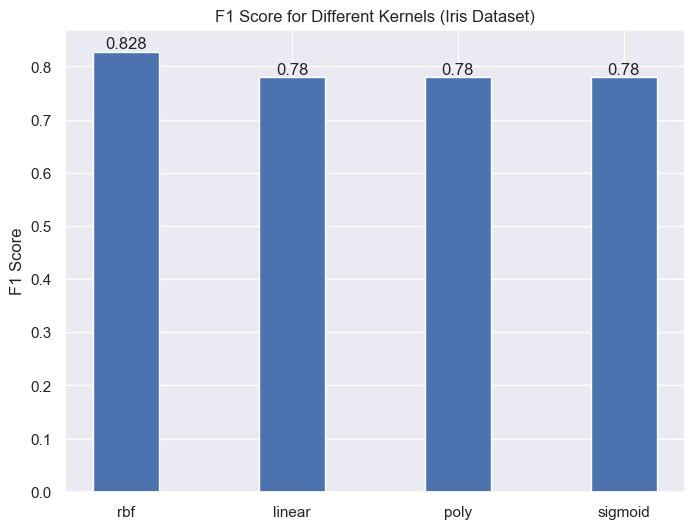

In [155]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Add the rounded values on top of each bar
for i, value in enumerate(ds1_f1):
    rounded_value = round(value, 3)  # Round off to three decimal points
    plt.text(i, value, str(rounded_value), ha='center', va='bottom')

# Show the plot
plt.show()
